# Consumer Reviews Summarization - Project Part 2


[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Ariamestra/ConsumerReviews/blob/main/project_part2.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ariamestra/ConsumerReviews/blob/main/project_part2.ipynb)


## 1. Introduction
My project goal is to develop a baseline model using a Naive Bayes classifier, designed to summarize customer reviews. This is intended to help potential buyers quickly navigate through reviews when assessing a product. The system will focus on condensing the essential content of each review and its associated rating into a concise, single-sentence comment. These comments will be categorized as positive, neutral, or negative, aligning with the review's original rating. This approach will simplify the review evaluation process, making it more efficient.<br>
<br>
**Data** <br>
The dataset was sourced from Kaggle, specifically the [Consumer Review of Clothing Product](https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product)
 dataset. This dataset includes customer reviews from Amazon. It has all sorts of feedback from buyers about different products. Along with the customers' actual reviews, ratings, product type, material, construction, color, finish, and durability.<br>



## Prep

In [74]:
# Import all of the Python Modules/Packages 
#!pip install -U imbalanced-learn
#!pip install keras
#!pip install tensorflow


import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.probability import FreqDist
from heapq import nlargest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE # Data transformer because when split traning data it 99% positive
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
from sklearn.metrics import confusion_matrix



from nltk.probability import FreqDist


# Now download NLTK resources
#nltk.download('stopwords')
#nltk.download('punkt')

data_URL = 'https://raw.githubusercontent.com/Ariamestra/ConsumerReviews/main/Reviews.csv'
df = pd.read_csv(data_URL)
print(f"Shape: {df.shape}")
df.head()

Shape: (49338, 9)


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


In [75]:
# Count the number of nulls in reviews
number_of_nulls = df['Review'].isnull().sum()
print(f"Number of nulls in the reviews: {number_of_nulls}")

# Calculate the number of nulls in rating
number_of_nulls_in_ratings = df['Cons_rating'].isnull().sum()
print(f"Number of nulls in the ratings: {number_of_nulls_in_ratings}")

original_count = df.shape[0]
df_cleaned = df.dropna(subset=['Review', 'Cons_rating']) # Drop rows with nulls in reviews and ratings columns
cleaned_count = df_cleaned.shape[0] # Number of rows after dropping nulls
rows_dropped = original_count - cleaned_count

print(f"Number of rows dropped: {rows_dropped}")

# Get the shape after dropping null values
df_shape_after_dropping = df_cleaned.shape

print(f"Shape of the DataFrame after dropping rows: {df_shape_after_dropping}")


Number of nulls in the reviews: 831
Number of nulls in the ratings: 214
Number of rows dropped: 1043
Shape of the DataFrame after dropping rows: (48295, 9)


In [76]:
# Add a new column 'Review_length' to df_cleaned with the length of each review
df_cleaned = df_cleaned.copy()
df_cleaned['Review_length'] = df_cleaned['Review'].apply(lambda x: len(str(x).split()))
#df_cleaned = df_cleaned.copy()
#df_cleaned['Review_length'] = df_cleaned['Review'].apply(lambda x: len(str(x).split()))

# Filter out reviews that are shorter than 20 words from df_cleaned
df_cleaned.drop(df_cleaned[df_cleaned['Review_length'] < 20].index, inplace=True)

# Longest and shortest reviews in df_cleaned
longest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmax()]
longest_review = longest_review_row['Review']
longest_review_length = longest_review_row['Review_length']

shortest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmin()]
shortest_review = shortest_review_row['Review']
shortest_review_length = shortest_review_row['Review_length']


print(f"Longest review length: {longest_review_length} words")
print(f"Shortest review length: {shortest_review_length} words")
print(f"Shape of the DataFrame after dropping rows below 20 words: {df_cleaned.shape}")



Longest review length: 668 words
Shortest review length: 20 words
Shape of the DataFrame after dropping rows below 20 words: (32857, 10)


In [77]:
# Tokenization and stop words removal
stop_words = set(stopwords.words('english'))

# Function to clean and process the text
def clean_review(review):
    review = str(review).lower()
    review = review.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stop words
    words = word_tokenize(review)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    # Join back into a string
    review = ' '.join(words)
    return review


print(f"Done")

Done


In [78]:
# Apply the text cleaning function to create the 'Processed_Review' column
df_cleaned['Processed_Review'] = df_cleaned['Review'].apply(clean_review)

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=0.05)

# Fit the vectorizer on the 'Processed_Review' column and transform it to get a feature matrix
X = tfidf_vectorizer.fit_transform(df_cleaned['Processed_Review'])

# Encode the 'Cons_rating' column if it is categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned['Cons_rating'])

# Now that X and y are defined, you can split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the total number 
total_samples = X.shape[0]
train_size = X_train.shape[0]
test_size = X_test.shape[0]

# Calculate the percentage 
train_percentage = (train_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

# Print out the sizes and percentages of the full dataset, training, and test sets
print(f"Total dataset size: {total_samples}")
print(f"Train size: {train_size} ({train_percentage:.2f}%)")
print(f"Test size: {test_size} ({test_percentage:.2f}%)")


Total dataset size: 32857
Train size: 26285 (80.00%)
Test size: 6572 (20.00%)


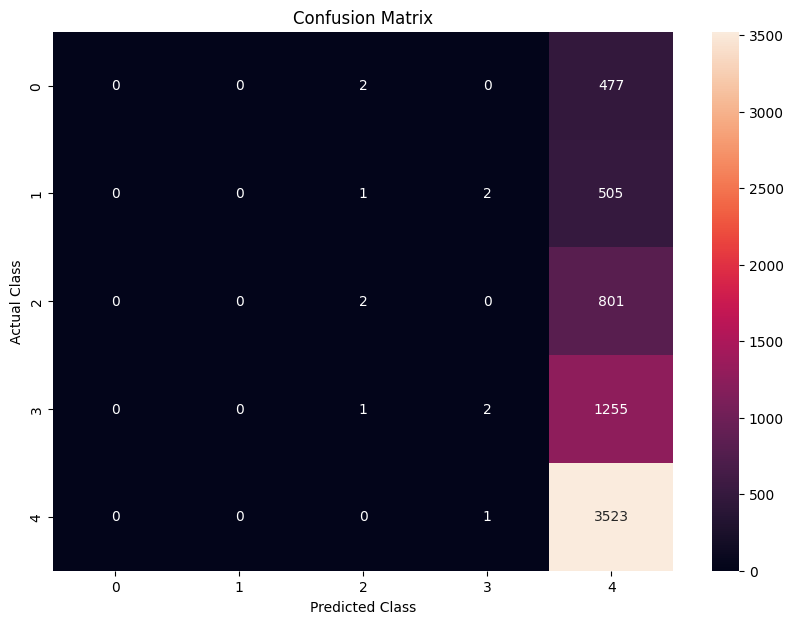

In [79]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



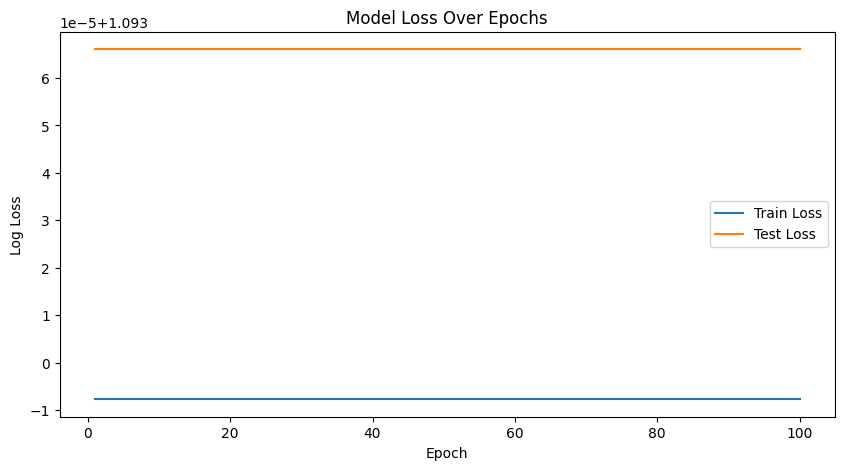

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the model in a pipeline that first scales the data
# Set 'with_mean=False' for sparse matrix compatibility
model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(solver='lbfgs', max_iter=1000))

# Fit the model to the training data
model.fit(X_train, y_train)

# Initialize lists to store the loss values
train_losses = []
test_losses = []

# Manually iterate over the epochs
for epoch in range(1, 101):  # Assuming you want to train for 100 epochs
    #model.fit(X_train, y_train)
    
    # Predict probabilities for the training and test sets
    train_pred_prob = model.predict_proba(X_train)
    test_pred_prob = model.predict_proba(X_test)
    
    # Calculate the log loss for the training and test sets
    train_loss = log_loss(y_train, train_pred_prob)
    test_loss = log_loss(y_test, test_pred_prob)
    
    # Store the log loss values
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot the actual training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), test_losses, label='Test Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


Train the Naive Bayes classifier

In [81]:
# Apply SMOTE to the training data
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['Processed_Review'])
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


Basline model

In [82]:
# Model Training
model = MultinomialNB()

# Correctly use X_train and y_train here
model.fit(X_train, y_train)

# Predictions
# Use X_test for making predictions
y_pred = model.predict(X_test)

# You should compare the predictions (y_pred) with the true labels (y_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5366707242848447


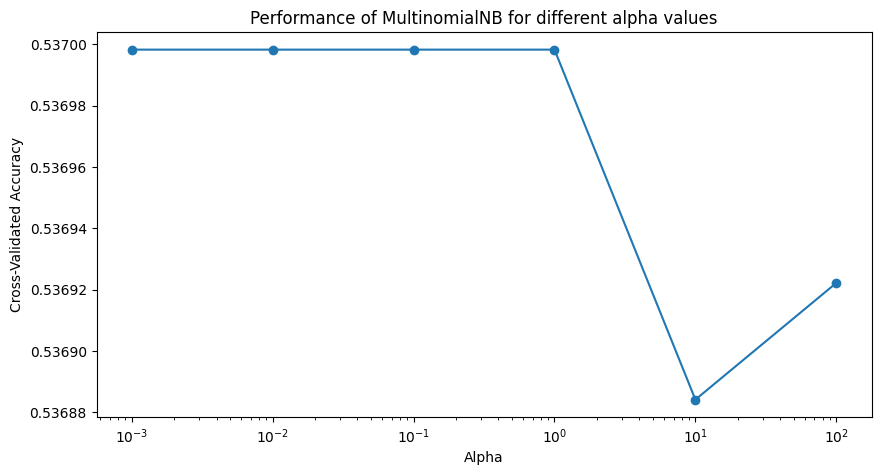

Best alpha: 0.001
Best cross-validated score: 0.5369982879969565


In [83]:


# Assuming X_train, X_test, y_train, y_test have already been defined and preprocessed...

# Define the parameter grid for 'alpha'
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alpha_values}

# Initialize the MultinomialNB classifier
nb_classifier = MultinomialNB()

# Initialize GridSearchCV
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Plot the results
mean_test_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(alpha_values, mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Performance of MultinomialNB for different alpha values')
plt.show()

# Get the best alpha value and its corresponding accuracy
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best cross-validated score: {best_score}")


In [84]:
# Sentiment
df['Sentiment_Summary'] = df['Cons_rating'].apply(lambda x: 'Negative' if x < 3 else ('Neutral' if x == 3 else 'Positive'))

df['Review_length'] = df['Review'].apply(lambda x: len(str(x).split()))

df_long_reviews = df[df['Review_length'] > 20]

# Display the first 5 original reviews with more than 20 words
for index, row in df_long_reviews.head(5).iterrows():
    print("Original Review:", row['Review'])
    # Assuming you have already created a 'Sentiment_Summary' column
    print("Predicted Sentiment:", row['Sentiment_Summary'])
    print('-' * 100)


Original Review: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Predicted Sentiment: Positive
----------------------------------------------------------------------------------------------------
Original Review: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c
Predicted Sentiment: Neutral
-

In [85]:
# ---------------------- Intaking sentiment -----------------------------
def summarize_review(review, num_sentences=2):

    stopWords = set(stopwords.words("english"))
    words = word_tokenize(review.lower()) 

    freqTable = FreqDist(words)
    sentences = sent_tokenize(review)
    sentenceValue = dict()

    for sentence in sentences:
        for word, freq in freqTable.items():
            if word in sentence.lower():
                if sentence in sentenceValue:
                    sentenceValue[sentence] += freq
                else:
                    sentenceValue[sentence] = freq

    summary_sentences = nlargest(num_sentences, sentenceValue, key=sentenceValue.get)
    summary = ' '.join(summary_sentences)
    return summary
df['Review'] = df['Review'].astype(str)

# Calculate the word count for each review
df['Word_Count'] = df['Review'].apply(lambda x: len(x.split()))

# Create a boolean mask for reviews with 20 words or more
mask = df['Word_Count'] >= 20

# Apply the mask to the DataFrame to keep only the longer reviews
df = df[mask]

# Apply the summarization function to your reviews
df['Summarized_Review'] = df['Review'].apply(summarize_review)

# Print the first 5 original and summarized reviews
for index, row in df.head(5).iterrows():
    original_review = row['Review']
    summarized_review = row['Summarized_Review']

    # Calculate word count
    original_word_count = len(original_review.split())
    summarized_word_count = len(summarized_review.split())

    print("Original Review:", original_review)
    print("Original Review Word Count:", original_word_count)
    print("Summarized Review:", summarized_review)
    print("Summarized Review Word Count:", summarized_word_count)
    print('-' * 100)

Original Review: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Original Review Word Count: 62
Summarized Review: i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. would definitely be a true midi on someone who is truly petite.
Summarized Review Word Count: 36
----------------------------------------------------------------------------------------------------
Original Review: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable 

## Conclusion